In [1]:
import pandas as pd
import numpy as np
import sklearn as sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import statistics as es 
import csv
import re 
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import interp
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
dataset = pd.read_csv ("dataset_final.csv")
#dataset.rename(columns={'TP_COR_RACA':'QT_COR_RACA'}, inplace = True)

In [3]:
print((dataset.TARGET==0).sum()/(dataset.TARGET.count())*100)

75.0


In [4]:
dataset.shape

(14376, 63)

Our dataset have a large amount of features due the School Census data. We wil try filter by context analisys and take off those are irrelevant to domain

In [5]:
# It already has a lot of features... let's take out those are irrelevant to domain and group the rest 
infrastructure = (['IN_AGUA_FILTRADA',
 'IN_ESGOTO_REDE_PUBLICA',
 'IN_ESGOTO_FOSSA',
 'IN_LABORATORIO_INFORMATICA',
 'IN_LABORATORIO_CIENCIAS',
 'IN_SALA_ATENDIMENTO_ESPECIAL',
 'IN_QUADRA_ESPORTES_COBERTA',
 'IN_QUADRA_ESPORTES_DESCOBERTA',
 'IN_QUADRA_ESPORTES',
 'IN_BIBLIOTECA',
 'IN_SALA_LEITURA',
 'IN_BANHEIRO_FORA_PREDIO',
 'IN_BANHEIRO_PNE',
 'IN_DEPENDENCIAS_PNE',
 'IN_BANHEIRO_CHUVEIRO',
 'IN_REFEITORIO',
 'IN_DESPENSA',
 'IN_ALMOXARIFADO',
 'IN_AUDITORIO',
 'IN_PATIO_COBERTO',
 'IN_PATIO_DESCOBERTO',
 'IN_AREA_VERDE',
 'QT_SALAS_UTILIZADAS',
 'QT_EQUIP_TV',
 'QT_EQUIP_DVD',
 'QT_EQUIP_COPIADORA',
 'QT_EQUIP_IMPRESSORA',
 'QT_EQUIP_IMPRESSORA_MULT',
 'QT_EQUIP_SOM',
 'QT_EQUIP_MULTIMIDIA',
 'QT_EQUIP_FOTO',
 'QT_COMP_ALUNO',
 'IN_BANDA_LARGA',
 'QT_FUNCIONARIOS'])

#infrastructure = (['IN_AGUA_FILTRADA','IN_ESGOTO_REDE_PUBLICA','IN_LABORATORIO_CIENCIAS','IN_QUADRA_ESPORTES_COBERTA'])

hypothesis = (['Q001', 'Q002', 'QT_TITULACAO'])


socioeconomic =(["Q003","Q004","Q005","Q006", 'Q007',"Q008","Q009","Q010","Q011","Q012","Q013","Q014",
                "Q015","Q016","Q017","Q018","Q019","Q020","Q021","Q022","Q023","Q024","Q025",
                 'QT_COR_RACA', "QT_IDADE" ])

target = (['TARGET'])

In [6]:
print(len(infrastructure),
len(hypothesis),
len(socioeconomic))

34 3 25


In [22]:
dataset.iloc[43].Q008

1.625

In [23]:
dataset = dataset[hypothesis + socioeconomic + infrastructure+target]
#dataset.shape
#dataset[infrastructure+target].to_csv('input0_infra.csv', index = False)
#dataset[hypothesis+target].to_csv('input0_hypo.csv', index = False)
dataset.to_csv('input0.csv', index = False)

In [7]:
scaler = MinMaxScaler()
x = dataset.values
x_scaled = scaler.fit_transform(x)
input = pd.DataFrame(x_scaled, columns = dataset.columns)
input.to_csv('input01.csv', index = False)

In [8]:
#scaler = StandardScaler()
#x = dataset[infrastructure+socioeconomic+hypothesis]
#scaler.fit(x)
#x_scaled= scaler.transform(x)
#input = pd.DataFrame(x_scaled, columns = x.columns)
#input = pd.merge(input, dataset['TARGET'], left_index=True, right_index=True)


In [9]:
X = input[infrastructure+socioeconomic+hypothesis]
y = input['TARGET']


## Analysis Model

In [10]:
logreg = LogisticRegression(class_weight='balanced')
param = {'C':[0.001,0.003,0.005,0.01,0.03,0.05,0.1,0.3,0.5,1,2,3,3,4,5,10,20]}
clf = GridSearchCV(logreg,param,scoring='roc_auc',refit=True,cv=10)
clf.fit(X,y)
print('Best roc_auc: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_))

Best roc_auc: 0.8718, with best C: {'C': 1}


In [24]:
clf.best_params_.dtypes

AttributeError: 'dict' object has no attribute 'dtypes'

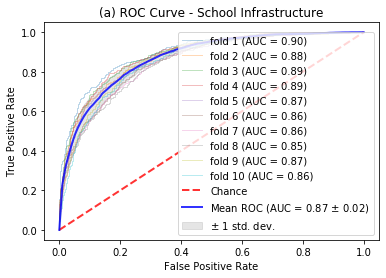

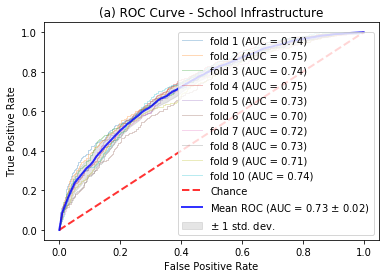

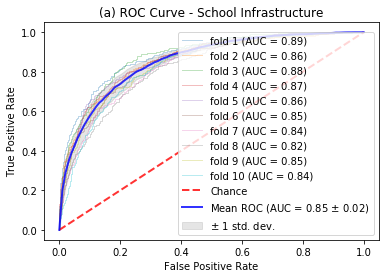

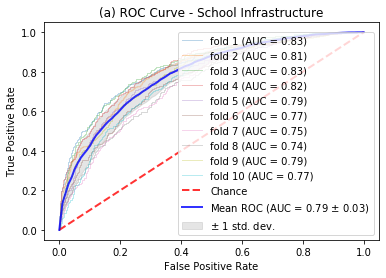

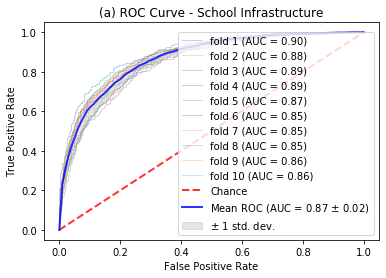

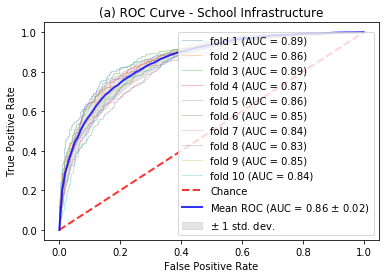

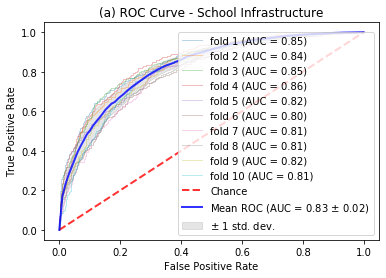

Index(['group', 'fpr', 'tpr', 'auc'], dtype='object')

In [29]:
skf = StratifiedKFold(n_splits=10,random_state=None)
groups ={}
groups['FULL'] = X
groups['1'] = X[infrastructure]
groups['2'] = X[socioeconomic]
groups['3'] = X[hypothesis]
groups['INFRA_SOCIO'] = X[infrastructure + socioeconomic]
groups['HYPO_SOCIO'] = X[hypothesis + socioeconomic ]
groups['HYPO_INFRA'] = X[hypothesis + infrastructure]

result_table = pd.DataFrame(columns=['fold','group', 'fpr','tpr','auc'])
lr = LogisticRegression(C=1)
    
for gp in groups:
    fig, ax = plt.subplots()  
    tprs = []
    aucs = []
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    i=1
    
    for train_index, test_index in skf.split(groups[gp],y):
            
    
        #print('{} of KFold {} in group {}'.format(i,skf.n_splits, gp))
        xtr,xvl = groups[gp].loc[train_index],groups[gp].loc[test_index]
        ytr,yvl = y.loc[train_index],y.loc[test_index]
        
        model = lr.fit(xtr,ytr)
        
        viz = plot_roc_curve(lr, xvl, yvl,
                         name='fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
        
        yproba = model.predict_proba(xvl)[:,1]
        
        fpr, tpr, _ = roc_curve(yvl,  yproba)
        score = roc_auc_score(yvl,yproba)
        
        interp_tpr = interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(score)
             
        
        result_table = result_table.append({'fold':i,'group':gp,
                                           'fpr': fpr,
                                           'tpr':tpr, 
                                           'auc': score}, ignore_index=True)
        i+=1
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="(a) ROC Curve - School Infrastructure")
    ax.legend(loc="lower right")
    plt.show()


result_table.set_index('fold', inplace=True)
result_table.columns
   
            

In [10]:
fig = plt.figure(figsize=(8,6))#

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
#plt.legend(prop={'size':13}, loc='lower right')

plt.show()

NameError: name 'result_table' is not defined

<Figure size 576x432 with 0 Axes>

In [ ]:
result = pd.DataFrame({'Mean':result_table.groupby(['group'])["auc"].mean(),
                       'STD': result_table.groupby(['group'])["auc"].std()}).reset_index()
result.sort_values('Mean', ascending = False)

In [ ]:
result_table.to_csv ("results.csv")